In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from scipy.stats import chi2_contingency, shapiro, ttest_ind 
from datetime import datetime

%matplotlib inline
plt.style.use('ggplot')

# Задание 1
_Написать функцию для расчета Retention._

Retention

What we need is to write a function to return the retention rate

We start with preparing the data we have.

In [3]:
reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

Info about registations data.

In [4]:
display(reg_data.head())
print(f"No. of registrations: {reg_data.shape[0]} \n")
display(reg_data.info())
print(f"Duplicates: {reg_data.duplicated().sum()}")

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


No. of registrations: 1000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


None

Duplicates: 0


Info about authorizations data

In [5]:
display(auth_data.head())
print(f"No. of authorizations (logins): {auth_data.shape[0]} \n")
display(auth_data.info())
print(f"Duplicates: {auth_data.duplicated().sum()}")

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


No. of authorizations (logins): 9601013 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


None

Duplicates: 0


Merging the tables to get one master table with all the data we need. 

In [6]:
df = reg_data.merge(auth_data, on=['uid'])
df = df.reindex(columns=['uid','reg_ts','auth_ts'])
df.head()

,uid,reg_ts,auth_ts
0,1,911382223,911382223
1,2,932683089,932683089
2,2,932683089,932921206
3,2,932683089,933393015
4,2,932683089,933875379


Converting unix time to standard datetime values using pd.to_datetime().

In [7]:
df.reg_ts = pd.to_datetime(df.reg_ts, unit='s')
df['reg_date'] = pd.to_datetime(df['reg_ts'].dt.date)
df.auth_ts = pd.to_datetime(df.auth_ts, unit='s')
df['auth_date'] = pd.to_datetime(df['auth_ts'].dt.date)
df = df.drop(['reg_ts', 'auth_ts'], axis=1)

In [8]:
df.head()

,uid,reg_date,auth_date
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


In [9]:
print(f"We got our first registration at {df.reg_date.min().date()}\n")
print(f"We got our latest registration at {df.reg_date.max().date()}\n")
print(f"We got our first authorization at {df.auth_date.min().date()}\n")
print(f"We got our latest authorization at {df.auth_date.max().date()}\n")

We got our first registration at 1998-11-18

We got our latest registration at 2020-09-23

We got our first authorization at 1998-11-18

We got our latest authorization at 2020-09-23



Now here's the function we may use to return the retention rate for given dates and data.

In [10]:
def retention(df, min, max):
    '''
    1. Get a dataframe df_temp, min and max dates as the time interval.
    2. Add a column life_time with number of days since registration.
    3. Make a pivot table and count unique uids for retention.
    4. Return visualization (heatmap).
    '''
    df_temp = df.query("reg_date > = @min & auth_date <= @max")
    df_temp['life_time'] = df_temp['auth_date'] - df_temp['reg_date']
    retention = df_temp.pivot_table(index='reg_date', columns='life_time', values='uid', aggfunc = 'nunique')
    retention = retention.divide(retention.iloc[:,0],axis='index').iloc[:-1, 1:].fillna(0).round(3)
    plt.figure(figsize=(20, 15))
    ax = sns.heatmap(retention, cmap="YlOrBr", annot=True, fmt=".1%", vmax=0.1, xticklabels = retention.columns.astype('str'), yticklabels = retention.index.astype('str'))
    ax.set_title(f" Retention rate between {df_temp['reg_date'].min().date()} and {df_temp['reg_date'].max().date()}", fontsize=18)
    sns.despine()  
    return ax

Let's try the function out

/var/folders/pm/mllw0fcj7wgfy7d2p8h5r5sh0000gn/T/ipykernel_34773/2984159462.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['life_time'] = df_temp['auth_date'] - df_temp['reg_date']


<AxesSubplot: title={'center': ' Retention rate between 2020-09-01 and 2020-09-23'}, xlabel='life_time', ylabel='reg_date'>

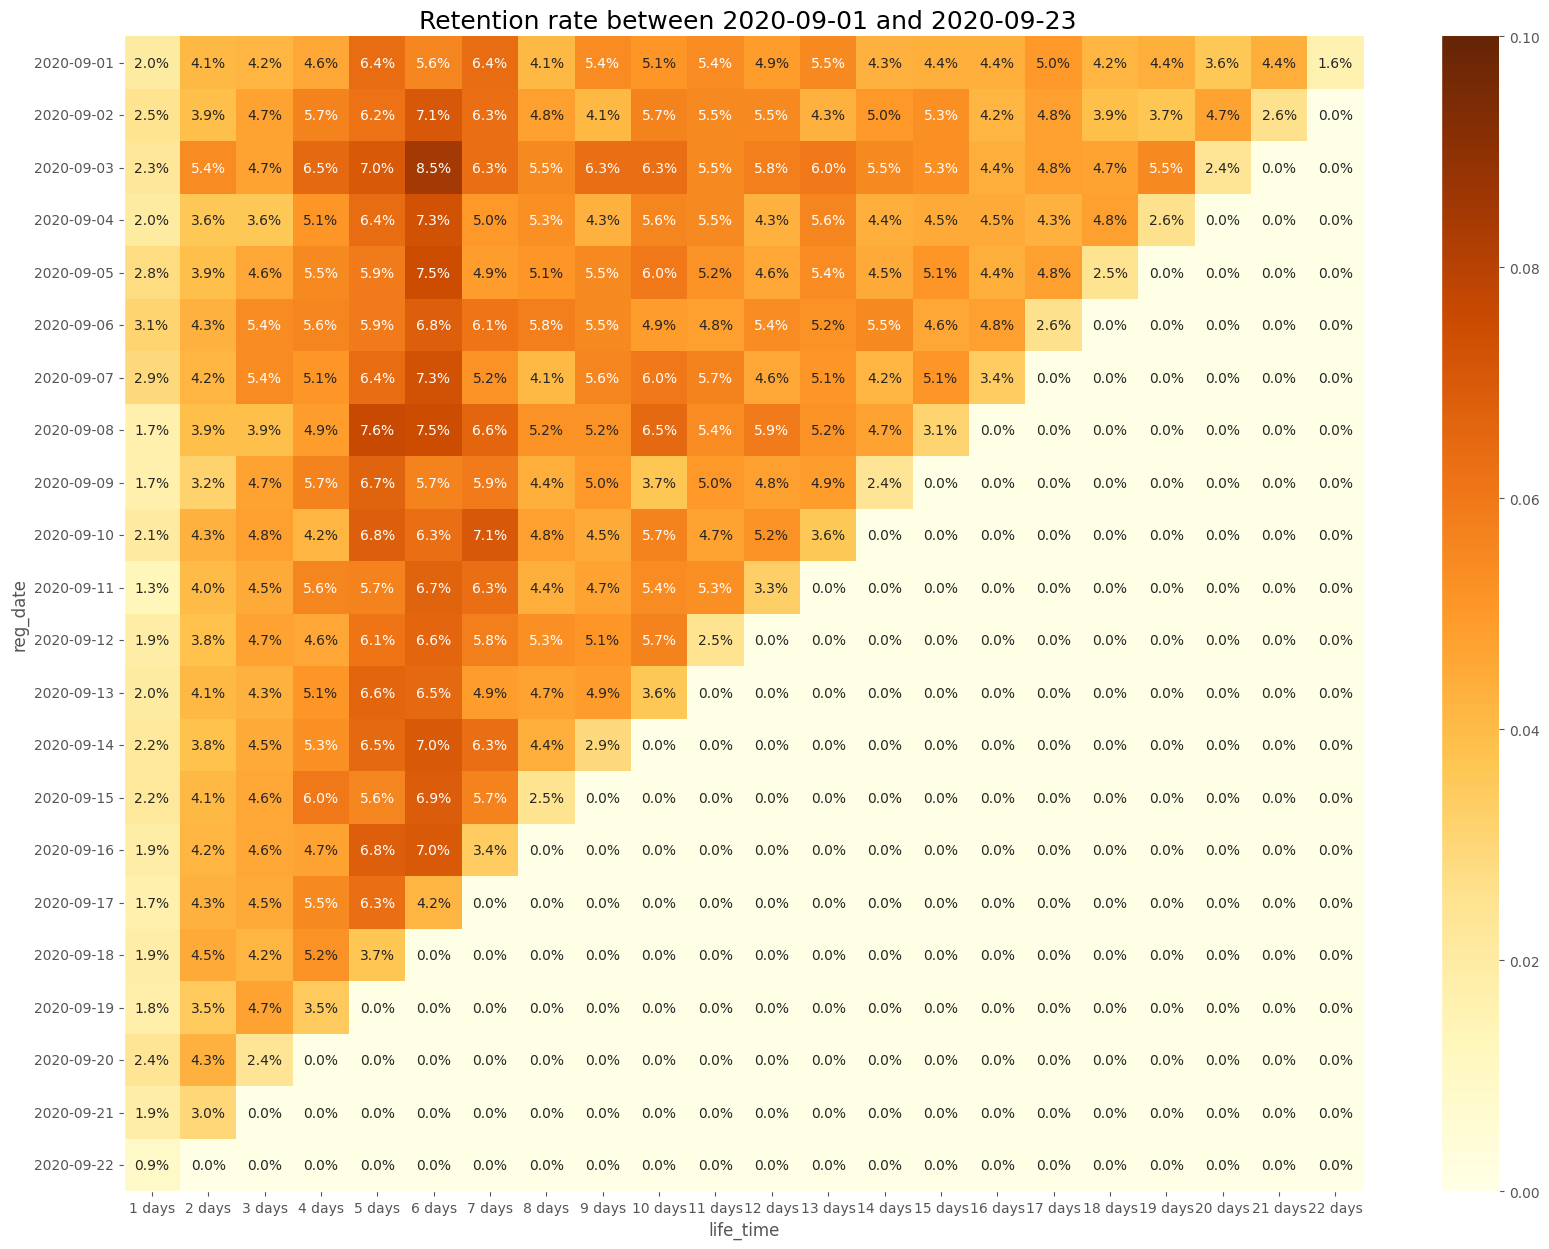

In [11]:
retention(df, min = '2020-09-01', max = '2020-09-30')

# Задание 2 

_Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667._

_Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?_

## Посмотрим на данные

In [12]:
df = pd.read_csv('/Users/dboldin/Downloads/Проект_1_Задание_2.csv', sep=';')

In [13]:
display(df.head())
print(f"No. of ids: {df.shape[0]} \n")
display(df.info())
print(f"Duplicates: {df.duplicated().sum()}")

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


No. of ids: 404770 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


None

Duplicates: 0


a - control group
b - test group

In [14]:
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [15]:
df_a = df.query("testgroup == 'a'")
df_b = df.query("testgroup == 'b'")

## Просчитаем метрики

Количество клиентов (платящих пользователей)

In [16]:
a_revenue = df_a.query("revenue > 0")
b_revenue = df_b.query("revenue > 0")

a_revenue_sum = df_a.revenue.sum()
b_revenue_sum = df_b.revenue.sum()

a_count = df_a.user_id.shape[0]
b_count = df_b.user_id.shape[0]

a_pay = a_revenue.revenue.shape[0]
b_pay = b_revenue.revenue.shape[0]

Конверсия

In [17]:
a_conv = round(a_pay / a_count * 100,2)
b_conv = round(b_pay / b_count * 100,2)

Средняя, медианная, максимальная, минимальная выручка

In [18]:
a_mean_revenue = a_revenue.revenue.mean()
b_mean_revenue = b_revenue.revenue.mean()
   
a_median_revenue = a_revenue.revenue.median()
b_median_revenue = b_revenue.revenue.median()

a_max_revenue = df_a.revenue.max()
b_max_revenue = df_b.revenue.max()

a_min_revenue = a_revenue.revenue.min()
b_min_revenue = b_revenue.revenue.min()

ARPU/ ARPPU

In [19]:
a_ARPPU = round(a_revenue_sum / a_pay)
b_ARPPU = round(b_revenue_sum / b_pay)

a_ARPU = a_conv * a_ARPPU
b_ARPU = b_conv * b_ARPPU

In [20]:
metrics = pd.DataFrame({'ids': [a_count, b_count],
              'paying_users': [a_pay, b_pay],
              'conversion':[a_conv, b_conv],
              'sum_revenue':[a_revenue_sum, b_revenue_sum],
              'mean_revenue':[a_mean_revenue, b_mean_revenue],
              'median_revenue':[a_median_revenue, b_median_revenue],
              'max_revenue':[a_max_revenue, b_max_revenue],
              'min_revenue':[a_min_revenue, b_min_revenue],
              'ARPU':[a_ARPU, b_ARPU],
              'ARPPU':[a_ARPPU, b_ARPPU]},
            index=['a_control', 'b_test'])
metrics

,ids,paying_users,conversion,sum_revenue,mean_revenue,median_revenue,max_revenue,min_revenue,ARPU,ARPPU
a_control,202103,1928,0.95,5136189,2663.998444,311.0,37433,200,2530.80,2664
b_test,202667,1805,0.89,5421603,3003.658172,3022.0,4000,2000,2673.56,3004


1. Конверсия в тестовой группе ниже на 6%
2. Суммарная выручка увеличилась на примерно 300 тыс.
3. Средняя выручка выросла на 400
4. Медианная - в 10 раз.

Все это + разброс максимальных и минимальных чеков позволяет сделать предположение, что в тестовой группе гораздо больше близких друг к другу значения выручки, а в контрольной очень много клиентов с низким чеком, но есть и небольшое число клиенты с очень большой выручкой.

То есть, если мы воспользуемся результатами А/Б теста и выкатим изменения на всю аудиторию, то "уплотним" значения полученной выручки. У нас будет меньше разрывов в тратах клиентов и в случае ухода этих "суперклиентов" мы не будем рисковать общей суммой выручки.

Посмотрим на распределения на графиках

<AxesSubplot: xlabel='revenue', ylabel='Count'>

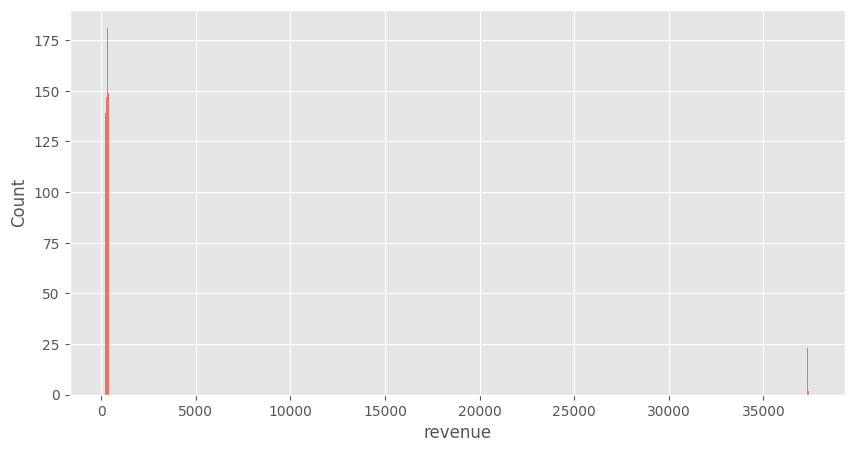

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(a_revenue.revenue)

<AxesSubplot: xlabel='revenue', ylabel='Count'>

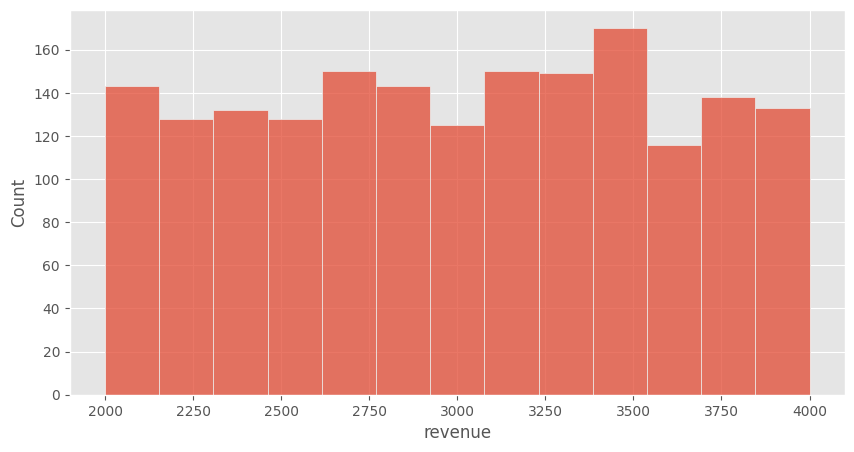

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(b_revenue.revenue)

На графиках выше видим распределение, визуально подтверждающее наши догадки о характере распределения чеков.

Посчитаем, какую долю дохода всей контрольной группы (testgroup==a) составляет правая часть клиентов (их мало, но они оставляют большУю часть денег).

In [23]:
max_spent_clients = df_a.query('revenue > 3000').user_id.nunique()
print(f"Клиентов в сегменте с наибольшим чеком: {max_spent_clients}")
print(f"Что составляет {round(max_spent_clients / df_a.user_id.nunique(), 5)*100} % от числа клиентов в контрольной группе")
print(f"Доля этих клиентов в общем объеме выручки: {round(df_a.query('revenue > 3000').revenue.sum() / df_a.query('revenue > 0').revenue.sum() * 100, 1)}%")

Клиентов в сегменте с наибольшим чеком: 123
Что составляет 0.061 % от числа клиентов в контрольной группе
Доля этих клиентов в общем объеме выручки: 89.4%


## Теперь необходимо проверить статистическую значимость полученных изменений в ARPU, ARPPU и конверсии

1. Проверим распределение средних на нормальность (тест Шапиро).
2. Првоерим дисперсии на гомогенность (тест Левена).
3. Применим т-тест для проверки наличия статистически значимой разницы между ARPU в двух группах
4. Повторим то же для ARPPU
5. Используем хи-квадрат в случае конверсии (создадим дихотомическую переменную "купил/ не купил")

### ARPU

Тест Шапиро. Применяем на сэмплированных выборках.

In [24]:
sample_means_a = []
sample_means_b = []
for i in range(100):
    sample_a = df_a.revenue.sample(frac=1, replace=True)
    sample_b = df_b.revenue.sample(frac=1, replace=True)
    
    sample_means_a.append(sample_a.mean())
    sample_means_b.append(sample_b.mean())
    
sp_a = shapiro(sample_means_a)

sp_b = shapiro(sample_means_b)

print(sp_a, sp_b)

ShapiroResult(statistic=0.9779605269432068, pvalue=0.0920826643705368) ShapiroResult(statistic=0.9734942317008972, pvalue=0.04115915298461914)


Принимаем, что средние распределены нормально, а значит можем перейти к проверке тестом Левена и далее к t-тесту.

Проверка тестом Левена на гомогенность дисперсий в группах. Результат выводим в табличку ниже.

In [25]:
pg.homoscedasticity(data=df, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


Переходим к проверке т-тестом

In [26]:
ttest_ind(df_a.revenue, df_b.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Т-тест показал отсутствие статистической значимости в разнице ARPU между контрольной и тестовой группами.

### ARPPU

In [27]:
sample_means_a = []
sample_means_b = []
for i in range(100):
    sample_a = a_revenue.revenue.sample(frac=1, replace=True)
    sample_b = b_revenue.revenue.sample(frac=1, replace=True)
    
    sample_means_a.append(sample_a.mean())
    sample_means_b.append(sample_b.mean())
    
sp_a = shapiro(sample_means_a)

sp_b = shapiro(sample_means_b)

print(sp_a, sp_b)

ShapiroResult(statistic=0.9797733426094055, pvalue=0.12763828039169312) ShapiroResult(statistic=0.988935649394989, pvalue=0.5795148015022278)


In [28]:
ttest_ind(a_revenue.revenue, b_revenue.revenue)

Ttest_indResult(statistic=-1.5917100176862005, pvalue=0.11153459157259497)

Для ARPPU также не видим статистически значимого эффекта от проведения а/б теста.

### Конверсия

Создадим дихотомическую переменную "купил/ не купил"

In [29]:
df['purchased'] = df.revenue > 0 

In [30]:
chi2_contingency(pd.crosstab(df.purchased, df.testgroup))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

Мы увидели, что различия в конверсии статистически значимы. Выведем еще раз фрейм со значением метрик.

In [31]:
metrics

,ids,paying_users,conversion,sum_revenue,mean_revenue,median_revenue,max_revenue,min_revenue,ARPU,ARPPU
a_control,202103,1928,0.95,5136189,2663.998444,311.0,37433,200,2530.80,2664
b_test,202667,1805,0.89,5421603,3003.658172,3022.0,4000,2000,2673.56,3004


## Выводы

На основе анализа трех метрик (ARPU, ARPPU, конверсия), на первый взгляд, у нас имеется только статистически значимая разница в конверсии на 6%. Это может напугать и заставить отказаться от предложения для тестовой группы.
Но характер изменений в структуре покупок клиентов не позволяет однозначно сказать "нет". В контрольной группе основная часть клиентов вносила небольшие платежи, малая часть (123 чел) внесли 90% выручки.
В тестовой группе гораздо более сглаженная картина чеков и в целом выручка больше на 285 тысяч.

Надо разбираться дальше и точно иметь какие-либо уточнения или больше информации об этом исследовании.


# Задание 3

_В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?_

1. DAU - анализируем, насколько подскочила аудитория в дни проведения событий
2. Retention - анализируем удержание клиентов при помощи событий (возвращаются ли пользователи в игру ради событий). Хотя тут надо понимать, что есть пользователи, которые и без событий возвращаются каждый день и верно интерпретировать возможноые скачки метрики.
3. Churn rate - анализируем отток пользователей
4. Конверсия - анализируем конверсию в покупку
5. ARPU/ARPPU - анализируем среднюю доходность с пользователей и платящих пользователей (покупателей внутриигровых предметов). Например, после события у пользователей проснулся интерес к игре и они совершили внутриигровые покупки
6. Время, затраченное на прохождение уровней (не слишком ли быстро, не слишком ли долго). В сравнении со временем нахождения в игре, но не в событии.
7. Воронку прохождения уровней (сколько человек отваливается на n-ном уровне). Возможно, где-то нужно подкрутить время на прохождение или сложность, чтобы меньше людей отваливалось и оставалось недовольными (как от чрезмерной сложности, так и от легкости). Тогда большее число довольных людей останется в игре и после события.

_Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?_

Понятно, что это нужно для того, чтобы вызвать азарт и заставить человека больше времени провести в игре во время события.
Значит нужно уделить особое внимание метрике кол-ва времени, проведенного в самом событии. Плюс отток пользователей, ведь это усложнение, а любое усложнение может вызвать негативную реакцию пользователей.
Плюс можно подкручивать число уровней, на которые откатывается игрок, и проверять отток.
Также можно анализировать изменение DAU при разной сложности.